<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/Media_Team_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#10조. 네이버 댓글 분석을 통한 상위, 하위 클립 예측

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls ../gdrive/My\ Drive/output

file_ep10.csv	 file_ep16.csv	file_ep22.csv  file_ep4.csv
file_ep11.csv	 file_ep17.csv	file_ep23.csv  file_ep5.csv
file_ep12.csv	 file_ep18.csv	file_ep24.csv  file_ep6.csv
file_ep13.csv	 file_ep19.csv	file_ep25.csv  file_ep7.csv
file_ep14_1.csv  file_ep1.csv	file_ep26.csv  file_ep8.csv
file_ep14.csv	 file_ep20.csv	file_ep2.csv   file_ep9.csv
file_ep15.csv	 file_ep21.csv	file_ep3.csv   TheLastEmpress.csv


In [3]:
!pip install regex

     |████████████████████████████████| 675kB 2.8MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609173 sha256=1090aca994b6a0270d4ee6ff2c65882ab4d49bf5ab4c67a07f4acef54ad2ad1b
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built regex


In [4]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys
import regex as re

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#데이터 분리를 위한 라이브러리 로드
from sklearn.model_selection import train_test_split

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


In [5]:
filelist = os.listdir('../gdrive/My Drive/output')
filelist

['file_ep1.csv',
 'file_ep16.csv',
 'file_ep17.csv',
 'file_ep10.csv',
 'file_ep14.csv',
 'file_ep12.csv',
 'file_ep11.csv',
 'file_ep14_1.csv',
 'file_ep15.csv',
 'file_ep13.csv',
 'file_ep18.csv',
 'file_ep19.csv',
 'file_ep21.csv',
 'file_ep20.csv',
 'file_ep2.csv',
 'file_ep22.csv',
 'file_ep23.csv',
 'file_ep25.csv',
 'file_ep24.csv',
 'file_ep26.csv',
 'file_ep3.csv',
 'file_ep4.csv',
 'file_ep5.csv',
 'file_ep6.csv',
 'file_ep9.csv',
 'file_ep7.csv',
 'TheLastEmpress.csv',
 'file_ep8.csv']

In [6]:
# 총 26회차 491개 하이라이트 클립 존재 (전체 재생수 = 107,221,654 / 클립 당 평균 재생수 = 218,374), 
# 이 중에서 예고편, 미공개, 인터뷰 등 클립 제외하고 총 422회 클립 대상
df_title = pd.read_csv('../gdrive/My Drive/output/TheLastEmpress.csv', encoding = 'euc-kr')
df_title.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 조회수 분포를 고려하여 각 회차별로 조회수 상위 4개, 하위 4개 클립을 샘플링 - 총 208개 클립
# 좋아요수, 댓글 수, 댓글 내용, 댓글 작성자 정보 (웹크롤링 통한 추출)

df_ep_tot = pd.DataFrame()
for i in tqdm_notebook(filelist):
  if (i[:4] == 'file'):
    df_ep_temp = pd.read_csv('../gdrive/My Drive/output/'+i)
    df_ep_temp['play'] = df_ep_temp['play'].apply(lambda x: int(re.sub(',','', x[4:])))
    df_ep_temp['rank'] = df_ep_temp['play'].rank(method='dense', ascending=False)
    df_ep_tot = df_ep_tot.append(df_ep_temp)

df_ep_tot.drop(columns='Unnamed: 0', inplace=True)
df_ep_tot['target'] = np.where(df_ep_tot['rank']<=4,1,0)
df_ep_tot

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1841,Major,와 ㅅㅂ...피지컬봐....,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1842,스폰지밥,"이쁘십니다 할때 나만설렜냐,,,,,,,",691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1844,김민정,죄송하지만 이 분 이용합시다 ! 어쨌든 좋은게 좋은거죠 ..,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0


In [7]:
display(df_title.head())
display(df_title.info())

,episode,title,play
0,14,"[숨멎 엔딩] 신성록, 설렘 폭발하는 반전 섹시미!",892539
1,8,"장나라, 악녀 이엘리야 때려잡는 카리스마 “얻다대고 반말”",852569
2,19,신은경 완벽 빙의한 ‘오아린 더빙 연기’,811897
3,10,"“사랑해요 폐하” 장나라, 신성록 계획 박살 내며 ‘흑화 스위치 ON’",757992
4,10,"뛰는 이엘리야 위 나는 오아린, 혼신의 눈물 연기(Feat. 윤소이 불꽃 따귀)",725808


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 3 columns):
episode    422 non-null int64
title      422 non-null object
play       422 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.0+ KB


None

In [8]:
display(df_ep_tot.head())
display(df_ep_tot.info())
# df_ep_tot[df_ep_tot['episode'] == 1].sample(10).sort_values(by='play', ascending = False)

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40935 entries, 0 to 1845
Data columns (total 11 columns):
nick           40935 non-null object
contents       40801 non-null object
recomm         40935 non-null int64
unrecomm       40935 non-null int64
title          40935 non-null object
play           40935 non-null int64
like           40935 non-null object
reple_count    40935 non-null object
episode        40935 non-null int64
rank           40935 non-null float64
target         40935 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


None

In [9]:
df_ep_sample = df_ep_tot.copy()
df_ep_sample.dropna(how='any', inplace=True)
df_ep_sample.info()
df_ep_sample['target'].value_counts() # 3:1 imbalanced dataset (조회수가 많은 클립에 댓글이 많기 때문임))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40801 entries, 0 to 1845
Data columns (total 11 columns):
nick           40801 non-null object
contents       40801 non-null object
recomm         40801 non-null int64
unrecomm       40801 non-null int64
title          40801 non-null object
play           40801 non-null int64
like           40801 non-null object
reple_count    40801 non-null object
episode        40801 non-null int64
rank           40801 non-null float64
target         40801 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


1    30632
0    10169
Name: target, dtype: int64

### 데이터 정제 - 정규식 & 형태소 분석

In [0]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample.dropna(how='any', inplace=True)
# df_sample_final = df_ep_sample.sample(frac=0.1).reset_index(drop=True).copy()
# df_sample_final = pd.concat([df_ep_sample[df_ep_sample['target']==1].sample(n=10000), df_ep_sample[df_ep_sample['target']==0].sample(n=10000)])
# df_sample_final.sample(frac=1).reset_index(drop=True)
# df_sample_final['target'].value_counts()

In [11]:
!pip3 install konlpy

     |████████████████████████████████| 19.4MB 432kB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
     |████████████████████████████████| 2.7MB 46.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [0]:
import konlpy
from konlpy.tag import Kkma, Okt
from konlpy.utils import pprint

okt =Okt()
# kkma = Kkma()
# mecab = Mecab()
# pprint(kkma.sentences(u'네, 안녕하세요. 반갑습니다.'))

# sentence = u'만 6세 이하의 초등학교 취학 전 자녀를 양육하기 위해서는'
# words = konlpy.tag.Twitter().pos(sentence)
# print(words)

In [0]:
def morphs_okt(x):
  res = okt.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = "NULL" if not res else res
  return res

# def morphs_kkma(x):
#   res = kkma.morphs(x)
#   if len(res) >= 1:
#     res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
#   else:
#     res = ''
#   res = "NULL" if not res else res
#   return res

In [14]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample['okt_token'] = df_ep_sample['contents'].apply(lambda x: morphs_okt(x))
# df_ep_sample['kkma_token'] = df_ep_sample['contents'].apply(lambda x: morphs_kkma(x))
df_ep_sample

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target,okt_token
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[옷, 입고, 목욕탕, 들어가는거, 웃기, 넼, 저, 거, 명품, 일, 텐데]"
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[왠지, 선, 황제, 가, 바람, 은, 못, 폈을거, 같다는, 생각, 이, 든다, ..."
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,NULL
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,NULL
4,홍홍,이게 나라냐 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[이, 게, 나라, 냐, 방송, 에서, 이딴, 수위, 가, 나오고, 지랄, 이야, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1841,Major,와 ㅅㅂ피지컬봐,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,"[와, 피지, 컬, 봐]"
1842,스폰지밥,이쁘십니다 할때 나만설렜냐,691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,"[이쁘십니다, 할, 때, 나, 만, 설렜냐]"
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,[반했네]
1844,김민정,죄송하지만 이 분 이용합시다 어쨌든 좋은게 좋은거죠,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,"[죄송하지만, 이, 분, 이용, 합시다, 어쨌든, 좋, 은, 게, 좋은, 거, 죠]"


In [15]:
df_ep_token = df_ep_sample.drop(df_ep_sample[df_ep_sample['okt_token'] == "NULL"].index)
df_ep_token

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target,okt_token
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[옷, 입고, 목욕탕, 들어가는거, 웃기, 넼, 저, 거, 명품, 일, 텐데]"
5,앵그리햄,이엘리야님 진짜 예쁘다,8,1,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[이엘리야, 님, 진짜, 예쁘다]"
7,강민주,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ에쓰엠드립봐 ㅋ,6,1,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[에쓰, 엠, 드립, 봐]"
9,그리,토나와,4,6,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,[토나와]
10,ykr0****,페하 소리를 몇 번 하는거지,37,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[페하, 소리, 를, 몇, 번, 하는거지]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1841,Major,와 ㅅㅂ피지컬봐,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,"[와, 피지, 컬, 봐]"
1842,스폰지밥,이쁘십니다 할때 나만설렜냐,691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,"[이쁘십니다, 할, 때, 나, 만, 설렜냐]"
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,[반했네]
1844,김민정,죄송하지만 이 분 이용합시다 어쨌든 좋은게 좋은거죠,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0,"[죄송하지만, 이, 분, 이용, 합시다, 어쨌든, 좋, 은, 게, 좋은, 거, 죠]"


## 공통 영역: Word Embedding을 위한 Hyper parameter Tuning

the no of covarage  95  percent word length is  32.0
32


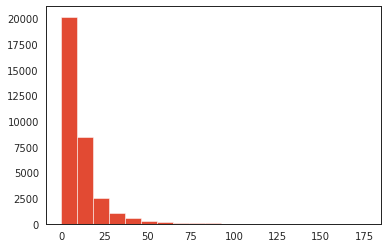

In [16]:
# Hyper Param setting

# token의 Histogram 분포를 바탕으로 대부분의 단어 길이 cover 가능한 단어 개수 찾기
# 신경망 학습을 위한 input 벡터 길이로 사용 - 적정 길이는 tokenizng 이후 분포를 보고 결정(코드 하단)
totalLenSent = [len(x) for x in df_ep_token['okt_token']] # 각 document의 단어 길이를 check
plt.hist(totalLenSent,bins = np.arange(0,max(totalLenSent),max(totalLenSent)/20))

coverage = 95
print("the no of covarage ", coverage, " percent word length is ", np.percentile(totalLenSent, coverage)) # 95%를 커버하는 수치는 41

# MAX_LEN = int(np.percentile(totalLenSent, coverage))
MAX_LEN = 32
print(MAX_LEN)

# input data 원문에서 보존할 최대 단어 개수 
# 전체 데이터셋에서 나타나는 unique 한 단어 수(넉넉하게 백단위 올림하여 setting)
# from itertools import chain

# sum_lists = list(chain.from_iterable(df_ep_token['okt_token']))
# totalCntWords = int(math.ceil(len(set(sum_lists))/100)*100)

# MAX_FEATURES = totalCntWords
# print(len(set(sum_lists)), MAX_FEATURES)

In [17]:
df_sample = pd.DataFrame()
df_sample['target'] = df_ep_token['target']
df_sample['contents'] = df_ep_token['okt_token'].apply(lambda x: ' '.join(x))
df_sample['target'].value_counts()

1    24882
0     8527
Name: target, dtype: int64

In [18]:
# df_sample_final = pd.concat([df_sample[df_sample['target']==1].sample(n=8000), df_sample[df_sample['target']==0].sample(n=8000)])
# df_sample_final.sample(frac=1).reset_index(drop=True)
df_sample_final = df_sample.sample(frac=1).reset_index(drop=True).copy()
df_sample_final['target'].value_counts()

1    24882
0     8527
Name: target, dtype: int64

## Bert

In [19]:
# Bert 친화 형식으로 변경
all_df_bert = pd.DataFrame({
    'id':range(len(df_sample_final)),
    'label':df_sample_final['target'],
    'alpha':['a']*df_sample_final.shape[0],
    'text': df_sample_final['contents'].replace(r'\n', ' ', regex=True)
})
display(all_df_bert.head())

# train_df_bert = pd.DataFrame({
#     'id':range(len(train_df)),
#     'label':train_df['target'],
#     'alpha':['a']*train_df.shape[0],
#     'text': train_df['contents'].replace(r'\n', ' ', regex=True)
# })

# display(train_df_bert.head())

# dev_df_bert = pd.DataFrame({
#     'id':range(len(test_df)),
#     'label':test_df['target'],
#     'alpha':['a']*test_df.shape[0],
#     'text': test_df['contents'].replace(r'\n', ' ', regex=True)
# })

# display(dev_df_bert.head())

,id,label,alpha,text
0,0,1,a,여 억 시 어마 마마 는 생각 이 깊으십니당
1,1,1,a,아 개귀여웤
2,2,1,a,아 진짜 이혁 은 쳐 죽일 놈 인데 진짜 성 록 배우 껍데기 는 죄 가 없다 안경 ...
3,3,1,a,혁써 니 연 기 캐 미
4,4,0,a,왕식 아 빨리 저승 이 만나러가야지


In [20]:
all_df_bert.to_csv('../gdrive/My Drive/data/bert/all.tsv', sep='\t', index=False, header=False)
# Create sentence and label lists
df_all = pd.read_csv("../gdrive/My Drive/data/bert/all.tsv", delimiter='\t', header=None, names = ['id', 'label', 'alpha', 'text'])
print(df_all.shape)
df_all.sample(5)

(33409, 4)


,id,label,alpha,text
25916,25916,1,a,가시 내 들 시간 조 낸 많네 한심하다
25425,25425,1,a,홍시
1275,1275,1,a,너무 소름 돋는다 날 죽이려 했던 남자 가 자자고 내 방 에 함부로 들어오는 것 모...
10323,10323,1,a,차라리 기억 잃은게 나을지도 그나저나 민 유라 양갈래 도 존예
15888,15888,1,a,할마 마마 오늘 죽을듯 민 유라 가 의도 치 않게 죽일것 같다 뒷 처리 는 아주 깔끔하게


In [21]:
!pip install sacremoses sentencepiece 

     |████████████████████████████████| 860kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=da7100ece5aa8f1fff82dc81d7b14bd3959468a89418f0040ca18b79d2053a78
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


### Pytorch 환경 내에서 BERT를 사용하기 위한 BERT 관련 Library Load

In [22]:
!pip install transformers

     |████████████████████████████████| 389kB 2.8MB/s 


In [0]:
import sacremoses
import sentencepiece

import pickle
import shutil
from joblib import Parallel, delayed

import torch
import torch.nn as nn # for neural net
import torch.utils.data
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all" # all, last, last_expr, none (기본값은 'last_expr')

# from transformers import convert_tf_checkpoint_to_pytorch
from transformers import convert_bert_original_tf_checkpoint_to_pytorch

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, BertModel, BertPreTrainedModel, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup

from transformers import BertConfig # This is the Bert configuration file

### Bert 관련 PATH 설정 (모델 PATH, TF CHECK POINT, BERT_CONFIG.JSON 등 로드)

In [24]:
!mkdir ./bert_work/
PATH_PRETRAINED = "../gdrive/My Drive/data/bert/multi_cased_L-12_H-768_A-12/"
PATH_TORCH_PRETRAINED = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased/"
PATH_HUGGING = "../gdrive/My Drive/data/bert/huggingface/"
PATH_WORK = './bert_work/'
sys.path.append(PATH_PRETRAINED)
sys.path.append(PATH_WORK)

BERT_MODEL_CONFIG = PATH_WORK+'config.json'

# 상기 내용 1회 시행 이후는 그냥 PATH_PRETRAINED의 변환 된 파일들을 PATH_WORK로만 복사
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-config.json', PATH_WORK + 'config.json')
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-vocab.txt', PATH_WORK + 'vocab.txt')

'./bert_work/config.json'

'./bert_work/pytorch_model.bin'

'./bert_work/vocab.txt'

### BERT 사용 관련 Hyperparameter Setting

In [25]:
seed = 888
MAX_SEQ_LEN = MAX_LEN # token분포 바탕으로 128 선정 (대부분의 단어 길이 cover)

NUM_LABELS = len(df_sample_final['target'].unique()) #2 If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy)
training_epochs = 10
lr = 2e-5
# lr = 5e-5
batch_size = 128

FILE_VOCAB = PATH_WORK+'vocab.txt'
# bert_model_config = PATH_WORK+'config.json'

bert_model = 'bert-base-multilingual-cased'
do_lower_case = 'uncased' in bert_model
device = torch.device('cuda') # GPU 사용 setting

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### 데이터를 불러와 Tokenizing 준비

In [26]:
sentences = df_all.text.values
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df_all.label.values
len(sentences)

33409

In [27]:
# tokenizer = BertTokenizer.from_pretrained(os.path.join(PATH_WORK, 'vocab.txt'), cache_dir=None, do_lower_case=do_lower_case, do_basic_tokenize=False)
# ['니', '##는', '[UNK]', '황', '##후', '##는', '이', '##짓', '##하면', '##안', '##돼', '##냐', '진', '##실을', '말', '##한', '##것', '뿐', '##인', '##데']

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=do_lower_case)
tokenizer = BertTokenizer.from_pretrained(FILE_VOCAB, cache_dir=None, do_lower_case=do_lower_case)

for i in range(0, len(sentences), 2000):
  sentence = sentences[i:(i+2000)] 
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentence]
  
  # 4000번에 한개씩 결과 출ㄹ력 
  if (i % 4000) == 0:
    print(tokenized_texts)
    
  input_ids_tmp = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  if i < 2:
    print(input_ids_tmp)

  input_ids_tmp = pad_sequences(input_ids_tmp, maxlen=MAX_LEN, dtype="long", truncating='post', padding='post')
  if i==0:
    input_ids = input_ids_tmp
    print(i)
  else:
    input_ids = np.vstack((input_ids, input_ids_tmp))
    print(i, '완료', input_ids.shape, input_ids_tmp.shape)

INFO:transformers.tokenization_utils:Model name './bert_work/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming './bert_work/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file ./bert_work/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file ./bert_work/special_tokens_map.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file ./bert_work/tokenizer_config.json. We won't load it.
INFO:transformers.t

[['[CLS]', '여', '억', '시', '어', '##마', '마', '##마', '는', '생', '##각', '이', '깊', '##으', '##십', '##니', '##당', '[SEP]'], ['[CLS]', '아', '[UNK]', '[SEP]'], ['[CLS]', '아', '진', '##짜', '이', '##혁', '은', '쳐', '죽', '##일', '놈', '인', '##데', '진', '##짜', '성', '록', '배우', '껍', '##데', '##기', '는', '죄', '가', '없다', '안', '##경', '쓴', '##더', '볼', '때', '마', '##다', '지', '##적', '인', '##데', '잘', '##생', '##겼', '##으면', '##서', '섹', '##시', '##한', '느', '##낌', '도', '있', '##음', '[SEP]'], ['[CLS]', '혁', '##써', '니', '연', '기', '캐', '미', '[SEP]'], ['[CLS]', '왕', '##식', '아', '빨', '##리', '저', '##승', '이', '만', '##나', '##러', '##가', '##야', '##지', '[SEP]'], ['[CLS]', '태', '##황', '##태', '##후', '마', '##마', '그', '##립', '##네', '##요', '[SEP]'], ['[CLS]', '[UNK]', '지', '그', '##래', '써', '##니', '엄', '##마', '한', '##테', '갈', '피', '일', '##것', '같', '##드', '라', '[SEP]'], ['[CLS]', '근', '##데', '마지막', '에', '폭', '##탄', '하', '##나', '더', '터', '##질', '때', '누', '##가', '폭', '##탄', '막', '##아', '##서', '이', '##혁', '이', '장', '##나라', '안', '##고', '나', '##갈'

In [28]:
np.save('wordpiece_tokenize_64.npy', input_ids)
input_ids = np.load('wordpiece_tokenize_64.npy')
print(input_ids.shape)
input_ids[:1]

(33409, 32)


array([[   101,   9565,   9547,   9485,   9546,  23811,   9246,  23811,
          9043,   9420,  66540,   9638,   8938, 119185, 119085,  25503,
         21928,    102,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0]])

## 분류에 사용할 클래스 Load

In [0]:
X = input_ids
Y = labels

# Train & Test Set 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=seed)

In [30]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(30068, 32) (3341, 32) (30068,) (3341,)


In [31]:
# Dataset을 상속한 TensorDataset은 train data x와 레이블 y를 묶어놓은 컨테이너로 tensor만 전달 가능함
# X는 torch.long 형태의 텐서로, y는 torch.float 타입의 텐서로 입력하여 pytorch에서 연산할 수 있는 기본 구조로 변경하여 train_dataset으로 할당
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x,dtype=torch.long), torch.tensor(train_y,dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x,dtype=torch.long), torch.tensor(test_y,dtype=torch.long))

print(train_x.shape)
print(train_y.shape)

(30068, 32)
(30068,)


In [0]:
train_losses = []

# Train 함수
def bert_train_net(net, train_loader, optimizer, device="cuda"):
  tq = tqdm_notebook(range(training_epochs))

  for epoch in tq:
    tr_loss = 0.
    nb_tr_examples, nb_tr_steps = 0,0

    # 신경망을 훈련 모드로 설정
    net.train()
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    
    # iteration 1회에 train_loader의 batch_size (여기서는 64)만큼씩 읽어와 한꺼번에 batch처리 batch_size * i (여기서는 i = ) 가 전체 train data set의 크기가 될때까지 loop
    for i,(x, y) in tk0:
      x=x.to(device) # len(x)는 batch_size
      y=y.to(device)

      loss, logit = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=y)  # forward

      optimizer.zero_grad() # step과 zero_grad는 쌍을 이루는 것이라고 생각하면 됨 # optimizer의 gradient를 0으로 초기화
      
      # if (i%200) == 0:
      #   print("logit is", logit, "real y is ", y)
      train_losses.append(loss.item())

      loss.backward() # backpropagation
      optimizer.step() # update gradients

      # update tracking variables
      tr_loss += loss.item()
      nb_tr_examples += x.size(0)
      nb_tr_steps += 1
      # running_loss += loss.item() # loss calculate

      train_losses.append(tr_loss/nb_tr_steps)

    print("epoch: {}/{} | train_loss: {:.4f} ".format(epoch, training_epochs, tr_loss/nb_tr_steps))
    # train_losses.append(running_loss/len(train_loader))
    # torch.save(model.state_dict(), output_model_file)

In [33]:
# BertForSequenceClassification is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. 
# As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

# Load pre-trained model (weights)

CACHE_DIR = 'cache/'

bert_config = BertConfig.from_json_file(BERT_MODEL_CONFIG)
bert_config.num_labels = NUM_LABELS

print("bert_config is ", bert_config)

# model = BertForSequenceClassification.from_pretrained(bert_model, cache_dir=CACHE_DIR, num_labels=NUM_LABELS)
model = BertForSequenceClassification.from_pretrained(PATH_WORK, num_labels=NUM_LABELS)

param_optimizer = list(model.named_parameters())
print("before adjust param_optimzer is ", param_optimizer[:1])

for p in model.bert.embeddings.parameters():
    p.requires_grad = False
print("after adjust param_optimzer is ", param_optimizer[:1])

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

### In Transformers, optimizer and schedules are splitted and instantiated like this:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, weight_decay = 0.1, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1, num_training_steps=2)  # PyTorch scheduler

INFO:transformers.configuration_utils:loading configuration file ./bert_work/config.json
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 119547
}

INFO:transformers.modeling_utils:loading weights file ./bert_work/pytorch_model.bin


bert_config is  {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 119547
}



INFO:transformers.modeling_utils:Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
INFO:transformers.modeling_utils:Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


before adjust param_optimzer is  [('bert.embeddings.word_embeddings.weight', Parameter containing:
tensor([[ 0.0260, -0.0062, -0.0041,  ...,  0.0297,  0.0242,  0.0197],
        [ 0.0104, -0.0136,  0.0067,  ...,  0.0124,  0.0267,  0.0337],
        [ 0.0221, -0.0036,  0.0193,  ...,  0.0069,  0.0268,  0.0050],
        ...,
        [ 0.0068,  0.0189,  0.0267,  ...,  0.0229,  0.0647,  0.0437],
        [ 0.0184,  0.0148,  0.0243,  ...,  0.0321,  0.0071,  0.0204],
        [ 0.0214,  0.0188, -0.0134,  ..., -0.0060,  0.0058, -0.0059]],
       requires_grad=True))]
after adjust param_optimzer is  [('bert.embeddings.word_embeddings.weight', Parameter containing:
tensor([[ 0.0260, -0.0062, -0.0041,  ...,  0.0297,  0.0242,  0.0197],
        [ 0.0104, -0.0136,  0.0067,  ...,  0.0124,  0.0267,  0.0337],
        [ 0.0221, -0.0036,  0.0193,  ...,  0.0069,  0.0268,  0.0050],
        ...,
        [ 0.0068,  0.0189,  0.0267,  ...,  0.0229,  0.0647,  0.0437],
        [ 0.0184,  0.0148,  0.0243,  ...,  0.03

In [34]:
model.to(device) # GPU 연산을 위해 cuda로 전송

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
bert_train_net(model, train_loader, optimizer, device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

epoch: 0/10 | train_loss: 0.5422 


epoch: 1/10 | train_loss: 0.5032 


epoch: 2/10 | train_loss: 0.4685 


epoch: 3/10 | train_loss: 0.4349 


epoch: 4/10 | train_loss: 0.3961 


epoch: 5/10 | train_loss: 0.3452 


epoch: 6/10 | train_loss: 0.3047 


epoch: 7/10 | train_loss: 0.2661 


epoch: 8/10 | train_loss: 0.2258 


epoch: 9/10 | train_loss: 0.1957 



<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Training loss')

Text(0.5, 0, 'Batch')

Text(0, 0.5, 'Loss')

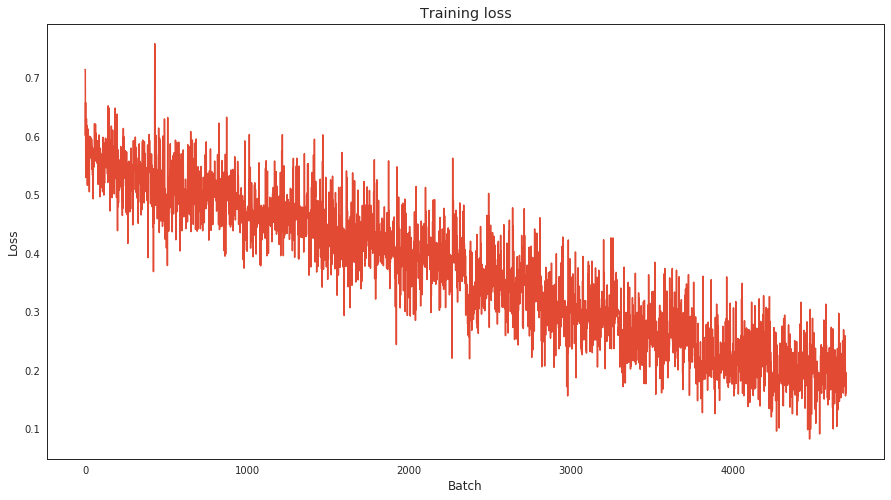

In [35]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

In [0]:
preds = []
labels = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(y_preds, real_ys):
    pred_flat = np.argmax(y_preds, axis=1).flatten()
    labels_flat = real_ys.flatten()
    print("pred_flat is ", pred_flat)
    print("labels_flat is ", labels_flat)
    preds.append(pred_flat)
    labels.append(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# 평가 헬퍼 함수
def bert_eval_net(net, data_loader, device="cuda"):
  # Dropout 및 BatchNorm 무효화
  net.eval()

  eval_acc = 0
  nb_eval_examples, nb_eval_steps = 0,0

  for x, y in data_loader:
    x=x.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_preds = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=None)  # forward

    #Move logits and labels to CPU
    y_preds = y_preds[0].detach().cpu().numpy()
    real_ys = y.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(y_preds, real_ys)
    print("tmp_eval_accuracy : ", tmp_eval_accuracy)

    eval_acc += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_acc/nb_eval_steps))

In [38]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
bert_eval_net(model, test_loader, device)

pred_flat is  [1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
labels_flat is  [1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0
 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1]
tmp_eval_accuracy :  0.828125
pred_flat is  [1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0
 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0]
labels_flat is  [1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1

In [0]:
def result_summary(pred_y, real_y):
  print("Accuracy: {:.4f}".format(accuracy_score(real_y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(real_y, pred_y))
  print("Classification Report Matrix: \n", classification_report(real_y, pred_y, digits=3))

  roc_auc = roc_auc_score(real_y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(real_y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

Accuracy: 0.8243
Confusion Matrix: 
 [[ 604  286]
 [ 301 2150]]
Classification Report Matrix: 
               precision    recall  f1-score   support

           0      0.667     0.679     0.673       890
           1      0.883     0.877     0.880      2451

    accuracy                          0.824      3341
   macro avg      0.775     0.778     0.776      3341
weighted avg      0.825     0.824     0.825      3341

roc_auc score is : 0.7779


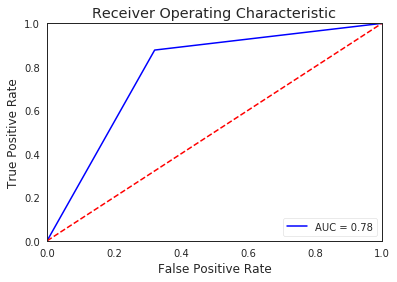

In [42]:
import itertools
preds_flat = list(itertools.chain(*preds))
labels_flat = list(itertools.chain(*labels))

result_summary(preds_flat, labels_flat)